<a href="https://colab.research.google.com/github/praneelseth/inspiritAIprojects/blob/master/Praneel_Seth_DistractedDrivers_Section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be:
1.   Visualizing Saliency Maps
2.   Evaluating our ML Models


# Milestone 1: Saliency maps

<font color="#de3023"><h2><b>Note: these blocks will take a minute to execute, so make sure to run them first thing!</b></h2></font>


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')
!pip install tf-keras-vis tensorflow

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest

    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()



  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))

    for layer in model.layers:
      if hasattr(layer,"activation"):
        stringlist.append(str(layer.activation))

    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
# image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
# metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

###
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

#monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 5.6 MB/s eta 0:00:00
metadata.csv        100%[===================>] 200.33K   602KB/s    in 0.3s    
image_data.npy      100%[===================>] 423.61M  21.5MB/s    in 21s     


Before we get started, let's load in a CNN model as we did in the previous day. For convenience, we provide this code for you to get you started.

**Run the below code. You are now very familiar with this code!**

Epoch 1/50
207/211 [============================>.] - ETA: 0s - loss: 1.3741 - accuracy: 0.3207

211/211 [==============================] - 8s 12ms/step - loss: 1.3730 - accuracy: 0.3215 - val_loss: 1.3589 - val_accuracy: 0.4185
Epoch 2/50
205/211 [============================>.] - ETA: 0s - loss: 1.2684 - accuracy: 0.4186

211/211 [==============================] - 2s 7ms/step - loss: 1.2676 - accuracy: 0.4186 - val_loss: 1.3215 - val_accuracy: 0.3043
Epoch 3/50
210/211 [============================>.] - ETA: 0s - loss: 1.1403 - accuracy: 0.5257

211/211 [==============================] - 2s 9ms/step - loss: 1.1400 - accuracy: 0.5260 - val_loss: 1.2992 - val_accuracy: 0.3120
Epoch 4/50
205/211 [============================>.] - ETA: 0s - loss: 1.0190 - accuracy: 0.5904

211/211 [==============================] - 2s 9ms/step - loss: 1.0173 - accuracy: 0.5919 - val_loss: 1.3108 - val_accuracy: 0.3609
Epoch 5/50
210/211 [============================>.] - ETA: 0s - loss: 0.8959 - accuracy: 0.6671

211/211 [==============================] - 2s 8ms/step - loss: 0.8959 - accuracy: 0.6672 - val_loss: 1.3252 - val_accuracy: 0.3663
Epoch 6/50
210/211 [============================>.] - ETA: 0s - loss: 0.7944 - accuracy: 0.7141

211/211 [==============================] - 2s 8ms/step - loss: 0.7945 - accuracy: 0.7142 - val_loss: 1.4925 - val_accuracy: 0.3228
Epoch 7/50
205/211 [============================>.] - ETA: 0s - loss: 0.7096 - accuracy: 0.7457

211/211 [==============================] - 2s 8ms/step - loss: 0.7087 - accuracy: 0.7464 - val_loss: 1.6145 - val_accuracy: 0.3196
Epoch 8/50
208/211 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.7805

211/211 [==============================] - 2s 9ms/step - loss: 0.6441 - accuracy: 0.7814 - val_loss: 1.6531 - val_accuracy: 0.3348
Epoch 9/50
205/211 [============================>.] - ETA: 0s - loss: 0.5661 - accuracy: 0.8188

211/211 [==============================] - 2s 8ms/step - loss: 0.5673 - accuracy: 0.8177 - val_loss: 1.7780 - val_accuracy: 0.3598
Epoch 10/50
210/211 [============================>.] - ETA: 0s - loss: 0.5178 - accuracy: 0.8356

211/211 [==============================] - 2s 10ms/step - loss: 0.5179 - accuracy: 0.8355 - val_loss: 1.8292 - val_accuracy: 0.3783
Epoch 11/50
210/211 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.8606

211/211 [==============================] - 2s 11ms/step - loss: 0.4627 - accuracy: 0.8606 - val_loss: 1.8707 - val_accuracy: 0.3587
Epoch 12/50
208/211 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8721

211/211 [==============================] - 2s 8ms/step - loss: 0.4239 - accuracy: 0.8717 - val_loss: 2.1824 - val_accuracy: 0.3174
Epoch 13/50
206/211 [============================>.] - ETA: 0s - loss: 0.3948 - accuracy: 0.8817

211/211 [==============================] - 2s 8ms/step - loss: 0.3943 - accuracy: 0.8821 - val_loss: 2.1638 - val_accuracy: 0.3304
Epoch 14/50
208/211 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8969

211/211 [==============================] - 2s 8ms/step - loss: 0.3605 - accuracy: 0.8969 - val_loss: 2.3820 - val_accuracy: 0.3250
Epoch 15/50
204/211 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.8992

211/211 [==============================] - 1s 5ms/step - loss: 0.3322 - accuracy: 0.9004 - val_loss: 2.3105 - val_accuracy: 0.3315
Epoch 16/50
200/211 [===========================>..] - ETA: 0s - loss: 0.3170 - accuracy: 0.9092

211/211 [==============================] - 1s 4ms/step - loss: 0.3169 - accuracy: 0.9093 - val_loss: 2.3089 - val_accuracy: 0.3576
Epoch 17/50
200/211 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.9153

211/211 [==============================] - 1s 4ms/step - loss: 0.2920 - accuracy: 0.9163 - val_loss: 2.6004 - val_accuracy: 0.3250
Epoch 18/50
206/211 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.9199

211/211 [==============================] - 1s 4ms/step - loss: 0.2803 - accuracy: 0.9197 - val_loss: 2.4991 - val_accuracy: 0.3739
Epoch 19/50
211/211 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9332

211/211 [==============================] - 1s 5ms/step - loss: 0.2531 - accuracy: 0.9332 - val_loss: 2.7870 - val_accuracy: 0.3250
Epoch 20/50
204/211 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9354

211/211 [==============================] - 1s 6ms/step - loss: 0.2368 - accuracy: 0.9358 - val_loss: 2.8702 - val_accuracy: 0.3261
Epoch 21/50
202/211 [===========================>..] - ETA: 0s - loss: 0.2292 - accuracy: 0.9372

211/211 [==============================] - 1s 6ms/step - loss: 0.2299 - accuracy: 0.9377 - val_loss: 3.0021 - val_accuracy: 0.3174
Epoch 22/50
209/211 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9402

211/211 [==============================] - 1s 4ms/step - loss: 0.2198 - accuracy: 0.9402 - val_loss: 3.0527 - val_accuracy: 0.3217
Epoch 23/50
203/211 [===========================>..] - ETA: 0s - loss: 0.2163 - accuracy: 0.9409

211/211 [==============================] - 1s 4ms/step - loss: 0.2150 - accuracy: 0.9414 - val_loss: 2.9579 - val_accuracy: 0.3533
Epoch 24/50
211/211 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9479

211/211 [==============================] - 1s 5ms/step - loss: 0.1975 - accuracy: 0.9479 - val_loss: 2.9967 - val_accuracy: 0.3315
Epoch 25/50
202/211 [===========================>..] - ETA: 0s - loss: 0.1907 - accuracy: 0.9500

211/211 [==============================] - 1s 4ms/step - loss: 0.1918 - accuracy: 0.9500 - val_loss: 3.2066 - val_accuracy: 0.3174
Epoch 26/50
204/211 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9501

211/211 [==============================] - 1s 4ms/step - loss: 0.1831 - accuracy: 0.9497 - val_loss: 3.3114 - val_accuracy: 0.3533
Epoch 27/50
209/211 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9590

211/211 [==============================] - 1s 4ms/step - loss: 0.1665 - accuracy: 0.9585 - val_loss: 3.4417 - val_accuracy: 0.3283
Epoch 28/50
209/211 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9577

211/211 [==============================] - 1s 5ms/step - loss: 0.1632 - accuracy: 0.9579 - val_loss: 3.3671 - val_accuracy: 0.3217
Epoch 29/50
204/211 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9574

211/211 [==============================] - 1s 4ms/step - loss: 0.1556 - accuracy: 0.9576 - val_loss: 3.4616 - val_accuracy: 0.3489
Epoch 30/50
211/211 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9643

211/211 [==============================] - 1s 4ms/step - loss: 0.1504 - accuracy: 0.9643 - val_loss: 3.3810 - val_accuracy: 0.3478
Epoch 31/50
201/211 [===========================>..] - ETA: 0s - loss: 0.1542 - accuracy: 0.9596

211/211 [==============================] - 1s 4ms/step - loss: 0.1537 - accuracy: 0.9598 - val_loss: 3.5602 - val_accuracy: 0.3272
Epoch 32/50
201/211 [===========================>..] - ETA: 0s - loss: 0.1395 - accuracy: 0.9630

211/211 [==============================] - 1s 5ms/step - loss: 0.1399 - accuracy: 0.9628 - val_loss: 3.6442 - val_accuracy: 0.3228
Epoch 33/50
211/211 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9659

211/211 [==============================] - 1s 6ms/step - loss: 0.1385 - accuracy: 0.9659 - val_loss: 3.6919 - val_accuracy: 0.3174
Epoch 34/50
209/211 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9649

211/211 [==============================] - 1s 5ms/step - loss: 0.1387 - accuracy: 0.9646 - val_loss: 3.8837 - val_accuracy: 0.3174
Epoch 35/50
198/211 [===========================>..] - ETA: 0s - loss: 0.1392 - accuracy: 0.9642

211/211 [==============================] - 1s 4ms/step - loss: 0.1383 - accuracy: 0.9639 - val_loss: 3.7584 - val_accuracy: 0.3196
Epoch 36/50
204/211 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9691

211/211 [==============================] - 1s 4ms/step - loss: 0.1232 - accuracy: 0.9697 - val_loss: 3.4148 - val_accuracy: 0.3620
Epoch 37/50
199/211 [===========================>..] - ETA: 0s - loss: 0.1230 - accuracy: 0.9677

211/211 [==============================] - 1s 4ms/step - loss: 0.1228 - accuracy: 0.9674 - val_loss: 3.5221 - val_accuracy: 0.3380
Epoch 38/50
197/211 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9683

211/211 [==============================] - 1s 4ms/step - loss: 0.1171 - accuracy: 0.9685 - val_loss: 3.7824 - val_accuracy: 0.3196
Epoch 39/50
204/211 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9688

211/211 [==============================] - 1s 4ms/step - loss: 0.1255 - accuracy: 0.9686 - val_loss: 4.1417 - val_accuracy: 0.3087
Epoch 40/50
207/211 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9748

211/211 [==============================] - 1s 4ms/step - loss: 0.1056 - accuracy: 0.9747 - val_loss: 4.2077 - val_accuracy: 0.3152
Epoch 41/50
209/211 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9702

211/211 [==============================] - 1s 5ms/step - loss: 0.1117 - accuracy: 0.9701 - val_loss: 3.8458 - val_accuracy: 0.3250
Epoch 42/50
202/211 [===========================>..] - ETA: 0s - loss: 0.0982 - accuracy: 0.9756

211/211 [==============================] - 1s 4ms/step - loss: 0.0972 - accuracy: 0.9758 - val_loss: 4.0249 - val_accuracy: 0.3239
Epoch 43/50
201/211 [===========================>..] - ETA: 0s - loss: 0.0953 - accuracy: 0.9761

211/211 [==============================] - 1s 4ms/step - loss: 0.0954 - accuracy: 0.9761 - val_loss: 4.1001 - val_accuracy: 0.3152
Epoch 44/50
201/211 [===========================>..] - ETA: 0s - loss: 0.0991 - accuracy: 0.9748

211/211 [==============================] - 1s 5ms/step - loss: 0.0995 - accuracy: 0.9749 - val_loss: 4.1886 - val_accuracy: 0.3174
Epoch 45/50
207/211 [============================>.] - ETA: 0s - loss: 0.0951 - accuracy: 0.9769

211/211 [==============================] - 1s 5ms/step - loss: 0.0945 - accuracy: 0.9771 - val_loss: 4.1112 - val_accuracy: 0.3185
Epoch 46/50
206/211 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9788

211/211 [==============================] - 1s 6ms/step - loss: 0.0892 - accuracy: 0.9787 - val_loss: 4.0078 - val_accuracy: 0.3348
Epoch 47/50
200/211 [===========================>..] - ETA: 0s - loss: 0.0895 - accuracy: 0.9769

211/211 [==============================] - 1s 5ms/step - loss: 0.0895 - accuracy: 0.9772 - val_loss: 4.1966 - val_accuracy: 0.3163
Epoch 48/50
207/211 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9774

211/211 [==============================] - 1s 4ms/step - loss: 0.0865 - accuracy: 0.9772 - val_loss: 4.3512 - val_accuracy: 0.3239
Epoch 49/50
210/211 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9801

211/211 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9801 - val_loss: 4.5952 - val_accuracy: 0.3152
Epoch 50/50
201/211 [===========================>..] - ETA: 0s - loss: 0.0810 - accuracy: 0.9799

211/211 [==============================] - 1s 4ms/step - loss: 0.0821 - accuracy: 0.9798 - val_loss: 4.4490 - val_accuracy: 0.3185
Epoch 1/50
211/211 [==============================] - ETA: 0s - loss: 1.3657 - accuracy: 0.3352

211/211 [==============================] - 10s 13ms/step - loss: 1.3657 - accuracy: 0.3352 - val_loss: 1.3246 - val_accuracy: 0.3413
Epoch 2/50
211/211 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.5263

211/211 [==============================] - 1s 7ms/step - loss: 1.1102 - accuracy: 0.5263 - val_loss: 1.2423 - val_accuracy: 0.3826
Epoch 3/50
211/211 [==============================] - ETA: 0s - loss: 0.7784 - accuracy: 0.6597

211/211 [==============================] - 1s 7ms/step - loss: 0.7784 - accuracy: 0.6597 - val_loss: 1.0330 - val_accuracy: 0.5522
Epoch 4/50
204/211 [============================>.] - ETA: 0s - loss: 0.6159 - accuracy: 0.7373

211/211 [==============================] - 1s 7ms/step - loss: 0.6149 - accuracy: 0.7388 - val_loss: 1.3137 - val_accuracy: 0.5228
Epoch 5/50
210/211 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7923

211/211 [==============================] - 2s 11ms/step - loss: 0.5086 - accuracy: 0.7922 - val_loss: 1.3766 - val_accuracy: 0.5228
Epoch 6/50
207/211 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.8441

211/211 [==============================] - 3s 13ms/step - loss: 0.4296 - accuracy: 0.8447 - val_loss: 1.3322 - val_accuracy: 0.5348
Epoch 7/50
209/211 [============================>.] - ETA: 0s - loss: 0.3693 - accuracy: 0.8698

211/211 [==============================] - 3s 15ms/step - loss: 0.3691 - accuracy: 0.8699 - val_loss: 1.8717 - val_accuracy: 0.4978
Epoch 8/50
210/211 [============================>.] - ETA: 0s - loss: 0.3115 - accuracy: 0.8964

211/211 [==============================] - 2s 8ms/step - loss: 0.3114 - accuracy: 0.8965 - val_loss: 1.6435 - val_accuracy: 0.5043
Epoch 9/50
211/211 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9127

211/211 [==============================] - 2s 8ms/step - loss: 0.2790 - accuracy: 0.9127 - val_loss: 1.4850 - val_accuracy: 0.5359
Epoch 10/50
208/211 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9268

211/211 [==============================] - 2s 7ms/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 2.1234 - val_accuracy: 0.4902
Epoch 11/50
206/211 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9351

211/211 [==============================] - 2s 7ms/step - loss: 0.2118 - accuracy: 0.9358 - val_loss: 1.8282 - val_accuracy: 0.5293
Epoch 12/50
207/211 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9441

211/211 [==============================] - 2s 7ms/step - loss: 0.1808 - accuracy: 0.9438 - val_loss: 1.4066 - val_accuracy: 0.5652
Epoch 13/50
210/211 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9543

211/211 [==============================] - 2s 9ms/step - loss: 0.1565 - accuracy: 0.9543 - val_loss: 1.9416 - val_accuracy: 0.5207
Epoch 14/50
207/211 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9594

211/211 [==============================] - 2s 9ms/step - loss: 0.1425 - accuracy: 0.9593 - val_loss: 1.9679 - val_accuracy: 0.5511
Epoch 15/50
207/211 [============================>.] - ETA: 0s - loss: 0.1308 - accuracy: 0.9609

211/211 [==============================] - 2s 7ms/step - loss: 0.1300 - accuracy: 0.9610 - val_loss: 2.1514 - val_accuracy: 0.4772
Epoch 16/50
209/211 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9644

211/211 [==============================] - 2s 7ms/step - loss: 0.1260 - accuracy: 0.9646 - val_loss: 1.9084 - val_accuracy: 0.5424
Epoch 17/50
210/211 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9732

211/211 [==============================] - 1s 7ms/step - loss: 0.0996 - accuracy: 0.9731 - val_loss: 1.8119 - val_accuracy: 0.5391
Epoch 18/50
209/211 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9735

211/211 [==============================] - 1s 7ms/step - loss: 0.0909 - accuracy: 0.9735 - val_loss: 2.2998 - val_accuracy: 0.4935
Epoch 19/50
209/211 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9755

211/211 [==============================] - 1s 7ms/step - loss: 0.0866 - accuracy: 0.9755 - val_loss: 2.2786 - val_accuracy: 0.5000
Epoch 20/50
211/211 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9755

211/211 [==============================] - 2s 7ms/step - loss: 0.0775 - accuracy: 0.9755 - val_loss: 2.5354 - val_accuracy: 0.4370
Epoch 21/50
208/211 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9781

211/211 [==============================] - 2s 9ms/step - loss: 0.0735 - accuracy: 0.9781 - val_loss: 2.1620 - val_accuracy: 0.5054
Epoch 22/50
203/211 [===========================>..] - ETA: 0s - loss: 0.0694 - accuracy: 0.9804

211/211 [==============================] - 2s 9ms/step - loss: 0.0682 - accuracy: 0.9808 - val_loss: 2.7866 - val_accuracy: 0.4326
Epoch 23/50
208/211 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9827

211/211 [==============================] - 2s 7ms/step - loss: 0.0606 - accuracy: 0.9826 - val_loss: 2.9733 - val_accuracy: 0.4250
Epoch 24/50
204/211 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9828

211/211 [==============================] - 1s 7ms/step - loss: 0.0546 - accuracy: 0.9829 - val_loss: 2.4086 - val_accuracy: 0.4859
Epoch 25/50
206/211 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.9847

211/211 [==============================] - 1s 7ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 2.2596 - val_accuracy: 0.5120
Epoch 26/50
207/211 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9851

211/211 [==============================] - 2s 7ms/step - loss: 0.0520 - accuracy: 0.9853 - val_loss: 2.4910 - val_accuracy: 0.4772
Epoch 27/50
207/211 [============================>.] - ETA: 0s - loss: 0.0440 - accuracy: 0.9875

211/211 [==============================] - 1s 7ms/step - loss: 0.0440 - accuracy: 0.9874 - val_loss: 2.4691 - val_accuracy: 0.4630
Epoch 28/50
203/211 [===========================>..] - ETA: 0s - loss: 0.0404 - accuracy: 0.9883

211/211 [==============================] - 2s 7ms/step - loss: 0.0405 - accuracy: 0.9884 - val_loss: 3.0140 - val_accuracy: 0.4413
Epoch 29/50
207/211 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9879

211/211 [==============================] - 2s 9ms/step - loss: 0.0367 - accuracy: 0.9878 - val_loss: 2.7786 - val_accuracy: 0.4533
Epoch 30/50
208/211 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9898

211/211 [==============================] - 2s 9ms/step - loss: 0.0312 - accuracy: 0.9899 - val_loss: 2.6620 - val_accuracy: 0.4848
Epoch 31/50
209/211 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9904

211/211 [==============================] - 2s 9ms/step - loss: 0.0298 - accuracy: 0.9905 - val_loss: 2.8197 - val_accuracy: 0.4500
Epoch 32/50
209/211 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9916

211/211 [==============================] - 2s 8ms/step - loss: 0.0286 - accuracy: 0.9917 - val_loss: 2.1904 - val_accuracy: 0.5761
Epoch 33/50
207/211 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9932

211/211 [==============================] - 2s 7ms/step - loss: 0.0247 - accuracy: 0.9930 - val_loss: 2.8124 - val_accuracy: 0.4674
Epoch 34/50
209/211 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9924

211/211 [==============================] - 2s 7ms/step - loss: 0.0225 - accuracy: 0.9924 - val_loss: 3.3375 - val_accuracy: 0.4283
Epoch 35/50
209/211 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9936

211/211 [==============================] - 1s 7ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 2.9775 - val_accuracy: 0.4609
Epoch 36/50
206/211 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9936

211/211 [==============================] - 2s 8ms/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 3.5593 - val_accuracy: 0.4337
Epoch 37/50
209/211 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9942

211/211 [==============================] - 2s 9ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 3.3921 - val_accuracy: 0.4326
Epoch 38/50
209/211 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9951

211/211 [==============================] - 2s 8ms/step - loss: 0.0146 - accuracy: 0.9951 - val_loss: 3.5227 - val_accuracy: 0.4511
Epoch 39/50
204/211 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9946

211/211 [==============================] - 1s 7ms/step - loss: 0.0154 - accuracy: 0.9948 - val_loss: 3.1883 - val_accuracy: 0.4652
Epoch 40/50
203/211 [===========================>..] - ETA: 0s - loss: 0.0182 - accuracy: 0.9949

211/211 [==============================] - 2s 7ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 2.9750 - val_accuracy: 0.4826
Epoch 41/50
206/211 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9954

211/211 [==============================] - 1s 7ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 3.6650 - val_accuracy: 0.4391
Epoch 42/50
209/211 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9955

211/211 [==============================] - 2s 9ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 3.5193 - val_accuracy: 0.4837
Epoch 43/50
211/211 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9961

211/211 [==============================] - 2s 9ms/step - loss: 0.0101 - accuracy: 0.9961 - val_loss: 4.2214 - val_accuracy: 0.4283
Epoch 44/50
210/211 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9951

211/211 [==============================] - 2s 9ms/step - loss: 0.0134 - accuracy: 0.9951 - val_loss: 2.9879 - val_accuracy: 0.5120
Epoch 45/50
203/211 [===========================>..] - ETA: 0s - loss: 0.0132 - accuracy: 0.9951

211/211 [==============================] - 2s 8ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 3.6574 - val_accuracy: 0.4478
Epoch 46/50
208/211 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9965

211/211 [==============================] - 2s 7ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 4.0387 - val_accuracy: 0.4511
Epoch 47/50
206/211 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9968

211/211 [==============================] - 2s 7ms/step - loss: 0.0085 - accuracy: 0.9969 - val_loss: 3.5810 - val_accuracy: 0.4761
Epoch 48/50
205/211 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9983

211/211 [==============================] - 2s 7ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 4.3431 - val_accuracy: 0.4457
Epoch 49/50
207/211 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964

211/211 [==============================] - 2s 7ms/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 3.5050 - val_accuracy: 0.4696
Epoch 50/50
206/211 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9976

211/211 [==============================] - 2s 7ms/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 3.8590 - val_accuracy: 0.4685
Dense


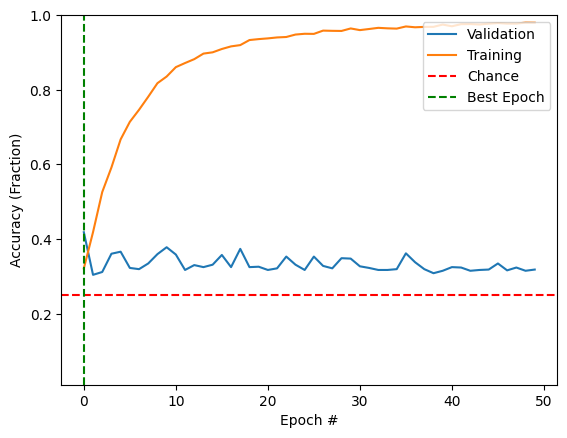

CNN


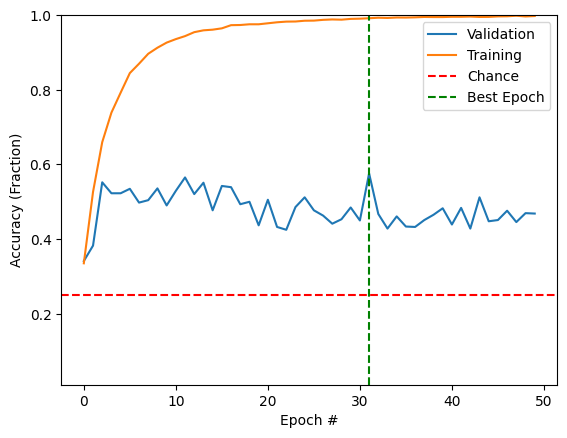

In [ ]:
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

dense = DenseClassifier(hidden_layer_sizes = (128,64))
cnn = CNNClassifier(num_hidden_layers = 5)

dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

print('Dense')
plot_acc(dense.history)

print('CNN')
plot_acc(cnn.history)

Now, let's view the saliency map of several of our images. A saliency map is used to visualize which pixels in an input image are the most influential, or **salient**, when the network is making a decision. In other words, this means that we can show which pixels in the input image the network is looking at when classifying an image.

One way to do this is by calculating the gradient on each pixel with respect to a given class score; that gradient will be steeper for pixels that influence the output a lot, and lower for pixels that didn't have much to do with the classification the model makes. (If this sounds familiar to you, you might be thinking of **backpropagation**, where a neural network corrects itself based on how much each node influences loss. They are similar in concept but not the same! If you are interested in learning about more about backpropagation, [this article](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd) is a good resource.)

In the following example, we show an photo of a tabby cat, and we're interested in which pixels were most important for the model when recognizing the cat. The pixels that were most important to the model will show up on a heatmap with warmer colors. This is one example of a **saliency map**.

![saliency_map](https://i.ibb.co/ygBG5Sb/tabby-heatmap.png)

If you want to explore saliency maps more, check out [this website](https://lrpserver.hhi.fraunhofer.de/image-classification) for an interactive demo.

In [ ]:
#@title Run this to prepare your saliency map visualization tools!
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

# save string versions of labels
train_labels_strings = train_labels
test_labels_strings = test_labels

# convert labels into numpy vectors (one-hot encoding!)
train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

replace2linear = ReplaceToLinear()

images = []
for i, title in enumerate(test_labels_strings):
  dim = (64, 64)
  img = np.array(cv2.resize(test_data[i], dim))
  images.append(img)
images = np.asarray(images)

def getImageSamples():
  image_samples = []
  image_samples_labels = []
  idx = random.randint(0, 230)
  for i in range(4):
    image_samples.append(images[idx])
    image_samples_labels.append(test_labels_strings[idx])
    idx = idx + 230
  image_samples = np.asarray(image_samples)
  return image_samples, image_samples_labels

def plot_vanilla_saliency_of_a_model(model, X_input, image_titles):
    score = CategoricalScore(list(range(X_input.shape[0])))

    # Create Saliency visualization object
    saliency = Saliency(model,
                        model_modifier=ReplaceToLinear(), # replaces the activation function of the chosen layer (here is the last layer) to linear function (for visualization)
                        clone=True)

    # Generate saliency map
    saliency_map = saliency(score, X_input)

    # Rendering
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(X_input[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot saliencies
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(saliency_map[i], cmap='jet')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

## Exercise: Saliency Map

Run this cell to view a saliency map for images from each distinct class.

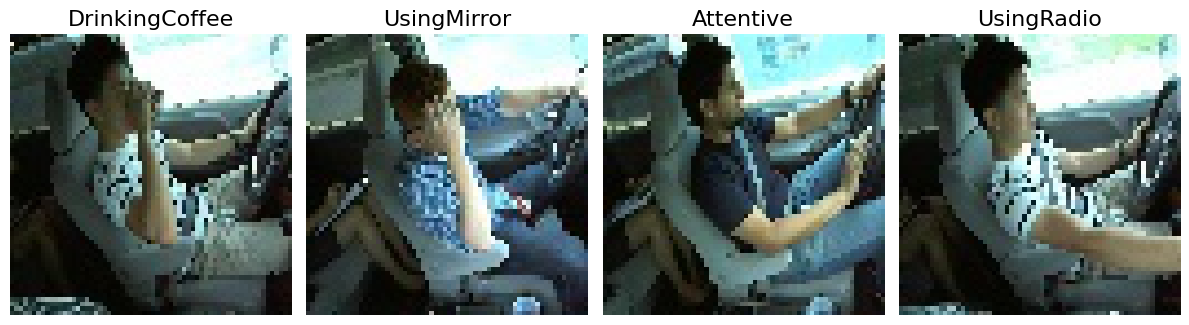

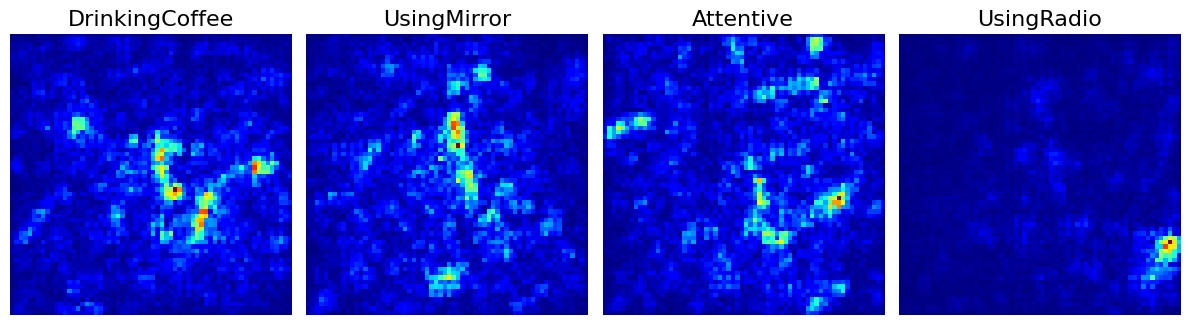

In [ ]:
imgs, imgs_labels = getImageSamples()
plot_vanilla_saliency_of_a_model(cnn, imgs, imgs_labels)

## Instructor-Led Discussion: Saliency maps

With your group, discuss:

**What differences do you notice between the saliency maps of the different classes?**

**What might be the underlying cause of these differences?**

## Optional Exercise: Saliency of your custom CNNs.

Develop your own custom CNN architectures in Keras/Tensorflow and see how their visual saliencies may differ across images.

Epoch 1/10
211/211 [==============================] - 5s 9ms/step - loss: 1.3715 - accuracy: 0.3056 - val_loss: 1.3649 - val_accuracy: 0.3913
Epoch 2/10
211/211 [==============================] - 1s 7ms/step - loss: 1.1982 - accuracy: 0.4658 - val_loss: 1.2450 - val_accuracy: 0.4435
Epoch 3/10
211/211 [==============================] - 1s 7ms/step - loss: 0.8401 - accuracy: 0.6367 - val_loss: 0.9896 - val_accuracy: 0.5239
Epoch 4/10
211/211 [==============================] - 1s 7ms/step - loss: 0.6461 - accuracy: 0.7133 - val_loss: 1.0662 - val_accuracy: 0.5413
Epoch 5/10
211/211 [==============================] - 2s 7ms/step - loss: 0.5285 - accuracy: 0.7786 - val_loss: 0.9957 - val_accuracy: 0.5402
Epoch 6/10
211/211 [==============================] - 1s 7ms/step - loss: 0.4545 - accuracy: 0.8211 - val_loss: 1.0914 - val_accuracy: 0.5663
Epoch 7/10
211/211 [==============================] - 2s 9ms/step - loss: 0.3763 - accuracy: 0.8656 - val_loss: 1.2546 - val_accuracy: 0.5217
Epoch 

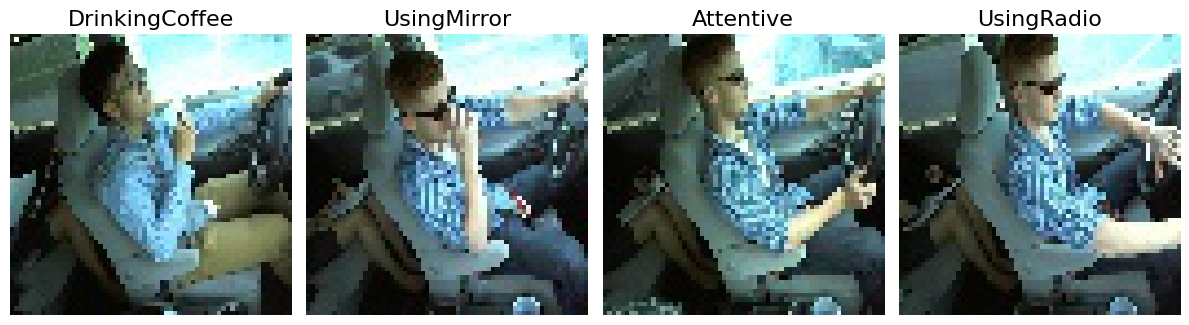

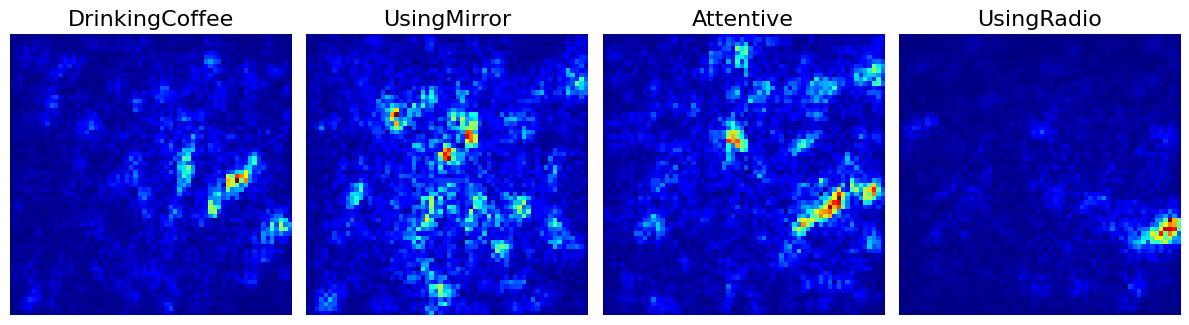

In [ ]:
### YOUR CODE HERE
cnn2 = CNNClassifier(num_hidden_layers=5)
cnn2.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True)

imgs, imgs_labels = getImageSamples()
plot_vanilla_saliency_of_a_model(cnn2, imgs, imgs_labels)
### END CODE

# Milestone 2: Model Evaluation

## Activity 2a. How did we do on predicting distracted drivers?

In [ ]:
#@title Run this cell to import and train the VGG16 model

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.applications.vgg16 import VGG16

# get data
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

# save string versions of labels
train_labels_strings = train_labels
test_labels_strings = test_labels

# convert labels into numpy vectors (one-hot encoding!)
train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

from tensorflow.keras.applications.vgg16 import VGG16

# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'softmax'))

# finally, we build the vgg model and turn it on so we can use it!
vgg_model.compile(loss = 'categorical_crossentropy',
          optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
          metrics=['accuracy'])

# grab our augmented training manual
# and hand it to our model to train
vgg_model.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True)


58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
211/211 [==============================] - 16s 58ms/step - loss: 0.8937 - accuracy: 0.6028 - val_loss: 0.7658 - val_accuracy: 0.7446
Epoch 2/10
211/211 [==============================] - 11s 50ms/step - loss: 0.1463 - accuracy: 0.9561 - val_loss: 1.8551 - val_accuracy: 0.5663
Epoch 3/10
211/211 [==============================] - 11s 55ms/step - loss: 0.1043 - accuracy: 0.9704 - val_loss: 1.0419 - val_accuracy: 0.6478
Epoch 4/10
211/211 [==============================] - 12s 58ms/step - loss: 0.0463 - accuracy: 0.9869 - val_loss: 1.1807 - val_accuracy: 0.7120
Epoch 5/10
211/211 [==============================] - 12s 59ms/step - loss: 0.0365 - accuracy: 0.9902 - val_loss: 1.7492 - val_accuracy: 0.6109
Epoch 6/10
211/211 [==============================] - 12s 55ms/step - loss: 0.0226 - accuracy: 0.9943 - val_loss: 1.6210 - val_accuracy: 0.6250
Epoch 7/10
211/211 [==============================] - 12s 58ms/step - l

### Exercise (Coding) | Within a student group

Use your best model from yesterday and train it again.

Epoch 1/20
210/211 [============================>.] - ETA: 0s - loss: 1.0336 - accuracy: 0.5385

211/211 [==============================] - 14s 53ms/step - loss: 1.0331 - accuracy: 0.5387 - val_loss: 1.0456 - val_accuracy: 0.6043
Epoch 2/20
210/211 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9469

211/211 [==============================] - 11s 51ms/step - loss: 0.1713 - accuracy: 0.9469 - val_loss: 1.8797 - val_accuracy: 0.5065
Epoch 3/20
210/211 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9811

211/211 [==============================] - 11s 52ms/step - loss: 0.0717 - accuracy: 0.9811 - val_loss: 1.1576 - val_accuracy: 0.6620
Epoch 4/20
210/211 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9891

211/211 [==============================] - 11s 52ms/step - loss: 0.0438 - accuracy: 0.9891 - val_loss: 1.1728 - val_accuracy: 0.6707
Epoch 5/20
210/211 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9937

211/211 [==============================] - 11s 52ms/step - loss: 0.0232 - accuracy: 0.9938 - val_loss: 1.2270 - val_accuracy: 0.6728
Epoch 6/20
210/211 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

211/211 [==============================] - 11s 53ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 1.2664 - val_accuracy: 0.6522
Epoch 7/20
210/211 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9955

211/211 [==============================] - 11s 54ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 1.7871 - val_accuracy: 0.6239
Epoch 8/20
210/211 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

211/211 [==============================] - 11s 53ms/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 1.9427 - val_accuracy: 0.6446
Epoch 9/20
210/211 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9987

211/211 [==============================] - 11s 54ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 1.1008 - val_accuracy: 0.7674
Epoch 10/20
210/211 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9958

211/211 [==============================] - 11s 53ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 1.5275 - val_accuracy: 0.6859
Epoch 11/20
210/211 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9988

211/211 [==============================] - 11s 52ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 1.7232 - val_accuracy: 0.6880
Epoch 12/20
211/211 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9993

211/211 [==============================] - 11s 53ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 1.4515 - val_accuracy: 0.7109
Epoch 13/20
210/211 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9997

211/211 [==============================] - 11s 54ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 1.7481 - val_accuracy: 0.6609
Epoch 14/20
210/211 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9996

211/211 [==============================] - 11s 54ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 2.0043 - val_accuracy: 0.6511
Epoch 15/20
210/211 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9975

211/211 [==============================] - 11s 53ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 1.3402 - val_accuracy: 0.7228
Epoch 16/20
210/211 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993

211/211 [==============================] - 11s 53ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 2.2425 - val_accuracy: 0.5967
Epoch 17/20
211/211 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997

211/211 [==============================] - 11s 53ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 2.7448 - val_accuracy: 0.5511
Epoch 18/20
210/211 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994

211/211 [==============================] - 11s 54ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 2.1839 - val_accuracy: 0.6011
Epoch 19/20
210/211 [============================>.] - ETA: 0s - loss: 8.5915e-04 - accuracy: 0.9999

211/211 [==============================] - 11s 54ms/step - loss: 8.5866e-04 - accuracy: 0.9999 - val_loss: 1.6265 - val_accuracy: 0.6696
Epoch 20/20
211/211 [==============================] - ETA: 0s - loss: 9.1592e-04 - accuracy: 0.9997

211/211 [==============================] - 11s 54ms/step - loss: 9.1592e-04 - accuracy: 0.9997 - val_loss: 1.9490 - val_accuracy: 0.6576


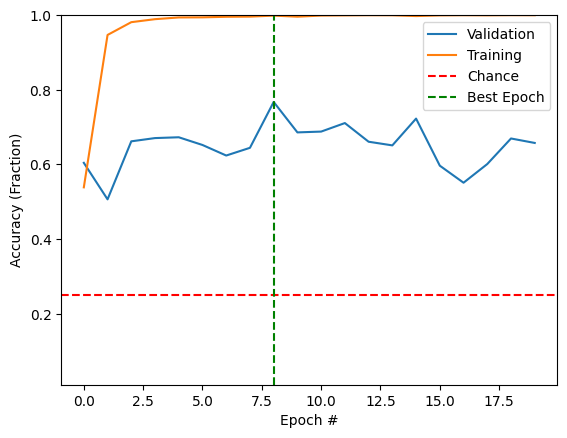

In [ ]:
### YOUR CODE HERE
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

vgg_model = Sequential()
vgg_model.add(vgg_expert)
vgg_model.add(GlobalAveragePooling2D()) # helps our vgg expert
vgg_model.add(Dense(1024, activation = 'relu')) # we've seen dense before!
vgg_model.add(Dropout(0.3)) # we've experimented with dropout before!
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'sigmoid')) # our output layer

vgg_model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                metrics=['accuracy'])

history = vgg_model.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

plot_acc(history)
### END CODE

As we learned last week, total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of detection of unsafe driving, we may be more interested in other quantities, such as 'how accurate were we on the distracted images?' or 'how accurate were we on the attentive category?' or 'how much of the attentive drivers were confused for distracted driving?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Distracted Driving (DrinkingCoffee, UsingMirror, or UsingRadio) = 1/Positive and Attentive = 0/Negative, then...

* True positive: True distracted driving prediction: Distracted driving predicted as distracted driving
* True negative: True attentive prediction: Attentive predicted as attentive
* False positive: False distracted driving prediction: Attentive mistaken as distracted driving
* False negative: False attentive prediction: Distracted driving mistaken as attentive


The `sklearn` package makes calculating confusion matrices very quick! Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - DISTRACTED DRIVING or 0 - ATTENTIVE)
* `predictions`: what our model thinks the labels are

To get `predictions`, we have to give our model our `test_data`, and ask it to give us `predictions`. We'll do that with

```
predictions = np.argmax(vgg_model.predict(test_data), axis=-1)
```

In [ ]:
predictions = vgg_model.predict(test_data)
predictions = np.argmax(predictions,axis=1)

29/29 [==============================] - 0s 16ms/step


## Exercise: Confusion matrix for distracted vs. non-distracted driving

First, write code below to calculate the accuracy of the classifier. Note that to complete this, you will need to transform the current 4-way classification into a binary (2-way) classification. That is, we will group all of UsingRadio, UsingMirror, and DrinkingCoffee into a single class representing all of distracted driving in general.

In [ ]:
### YOUR CODE HERE

# First, covert all of the labels to numbers.
# If the true label corresponds to Attentive (e.g., the vector looks like
# [1, 0, 0, 0]), then we add 0 (for attentive) to final_labels. Otherwise,
# for the vectors [0, 1, 0, 0], [0, 0, 1, 0], and [0, 0, 0, 1], we add a label
# of 1 (for distracted).
final_labels = []
for label in test_labels:
  if label[0]==1:
    final_labels.append(0)
  else:
    final_labels.append(1)
# FILL IN THIS LOOP

# Now, we change our final predictions to 0 and 1. That is, if the predictions
# currently is 0, then add 0 (for attentive) to binary_predictions. Otherwise,
# add 1.
binary_predictions = []
for label in predictions:
  if label==0:
    binary_predictions.append(0)
  else:
    binary_predictions.append(1)

  # FILL IN THIS LOOP

print('Accuracy is %d %%'%(accuracy_score(final_labels, binary_predictions)*100.0))

### END CODE

Accuracy is 86 %


### Discuss: Is this good accuracy?

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(final_labels, binary_predictions)
print(confusion)

tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

[[114 116]
 [ 10 680]]
True positive: 680
True negative: 114
False positive: 116
False negative: 10


We can visualize the confusion matrix with seaborn to make it easier for our eyes...

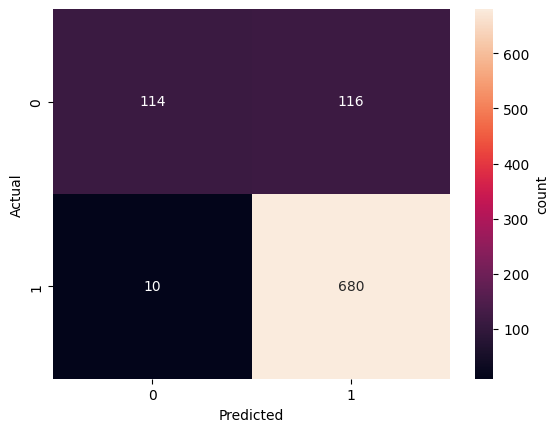

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

### Exercise (Discussion)

**Discuss with your instructor what you got and also...**

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?


## Exercise: Precision and Recall Calculation

Recall our discussion of precision and recall. Discuss with the course the difference between precision and recall. Then, print the precision and recall of the model and discuss with the class the implications of precision and recall in terms of distracted driving.

In [ ]:
## YOUR CODE HERE
tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print(tp/(tp+fp)) # precision: what percent of correct answers were correct?
print(tp/(tp+fn)) # recall
## END CODE

0.8542713567839196
0.9855072463768116



### Optional Exercise (Coding) | In group



If you're interested, you can try to calculate true/false positive/negative with your own code! Then, check how you did by comparing to the `sklearn.metrics` confusion matrix results.

Hint:
* `predictions` is an np array that looks like... `[1, 0, 0, 1, ...]`
* `test_labels` is an np array looks like... `[1, 0, 0, 1, ...]`

In [ ]:
### YOUR CODE HERE
confusion_matrix = [[]]
for i in len(predictions):
  if (predictions[i - 1] == test_labels[i - 1]) & predictions[i - 1] == 1:
    confusion_matrix = [1][1]
### END CODE

To recap, we built neural network models to see if we can do better than our simple logistic regression. It turns out that we can! And, also, by introducing convolutions to our networks (making the convolutional neural networks), we can improve by quite a lot. Finally, we employed pretrained 'expert' models to boost our performance even further.

# Challenge Exercise: Maintaining Privacy

A common problem in video recording is maintaining privacy of users. If you have time, add privacy to all of our training and test data by modifying the images to have red boxes over the faces. Then, retrain the CNN and evaluate the performance.

In [ ]:
### YOUR CODE HERE

### END CODE

# Fin!
